In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier  #
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
from keras.utils import to_categorical
import gc
from copy import deepcopy  
from functools import partial
import cmaes
import tensorflow as tf
from xgboost import XGBClassifier 

d:\Coding\forest_hack\.env\new_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
df = pd.read_csv("../Data/new_train.csv")
df["nforest_type"] = df["nforest_type"].map({'MDF': 0, 'DDF':1, 'DEF': 2})

In [3]:
df.head()

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,...,BRI,BWDRVI,ARVI2,ARVI,Ashburn_Vegetation_Index,ARI,Alteration_Index,AFVI_2100,AFVI_1600,Adjusted_TSAVI
0,2002,293,1927,1038,278,475,453,987,1773,2184,...,0.284783,0.074472,0.503165,0.412451,0.614960,0.001092,3.937583,0.037452,0.293397,-0.150281
1,3212,197,1598,697,201,347,228,682,1982,2449,...,0.487988,0.083625,0.796732,0.686706,0.816277,0.001416,4.187956,0.263939,0.527618,-0.381403
2,13312,929,1975,1031,982,1020,856,1220,2051,2421,...,0.254051,0.041790,0.532351,0.326779,0.472906,0.000161,1.501499,0.448565,0.397604,-0.229597
3,17020,132,1560,689,189,408,175,609,2117,2907,...,0.553191,0.088235,0.898901,0.803536,0.890591,0.000809,3.767169,0.321115,0.628872,-0.633802
4,5967,241,1944,1131,362,538,487,918,1549,1844,...,0.255776,0.064922,0.471046,0.358789,0.555048,0.000769,3.416667,0.039978,0.201553,-0.182600


In [4]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Get the counts of each class
# class_counts = Counter(df['nforest_type'])

# Separate features and target
X = df.drop(columns=['id','nforest_type'])
# X = df.drop(columns=['nforest_type'])
y = df['nforest_type']

# Instantiate the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Oversample the minority classes
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# Split the oversampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.1, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,  random_state=42)

# Standardizing the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# NN

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hyperparams):
    model = keras.Sequential()

    # Add a dense layer with predefined units and activation
    model.add(layers.Dense(
        units=hyperparams['units_1'],
        activation=hyperparams['activation_input'],
        input_shape=(200,),
    ))

    # Add dropout layers with predefined rates
    model.add(layers.Dropout(
        rate=hyperparams['dropout_1']
    ))

    model.add(layers.Dense(
        units=hyperparams['units_2'],
        activation=hyperparams['activation_input'],
        kernel_regularizer=tf.keras.regularizers.l1(hyperparams['l2_1'])
    ))

    model.add(layers.Dropout(
        rate=hyperparams['dropout_2']
    ))

    model.add(layers.Dense(
        units=hyperparams['units_3'],
        activation=hyperparams['activation_input'],
        kernel_regularizer=tf.keras.regularizers.l1(hyperparams['l2_2'])
    ))

    model.add(layers.Dropout(
        rate=hyperparams['dropout_3']
    ))

    model.add(layers.Dense(
        units=hyperparams['units_4'],
        activation=hyperparams['activation_input'],
        kernel_regularizer=tf.keras.regularizers.l1(hyperparams['l2_3'])
    ))

    model.add(layers.Dropout(
        rate=hyperparams['dropout_4']
    ))

    model.add(layers.Dense(
        units=hyperparams['units_5'],
        activation=hyperparams['activation_input'],
        kernel_regularizer=tf.keras.regularizers.l1(hyperparams['l2_4'])
    ))

    model.add(layers.Dropout(
        rate=hyperparams['dropout_5']
    ))

    model.add(layers.Dense(
        units=hyperparams['units_6'],
        activation=hyperparams['activation_input'],
        kernel_regularizer=tf.keras.regularizers.l1(hyperparams['l2_4'])
    ))

    model.add(layers.Dropout(
        rate=hyperparams['dropout_6']
    ))

    model.add(layers.Dense(
        units=hyperparams['units_7'],
        activation=hyperparams['activation_input'],
        kernel_regularizer=tf.keras.regularizers.l1(hyperparams['l2_4'])
    ))

    model.add(layers.Dropout(
        rate=hyperparams['dropout_7']
    ))

    # Output layer for 3-class classification
    model.add(layers.Dense(3, activation='softmax'))

    return model


In [31]:
import json
with open('best_hyperparameters.json', 'r') as f:
    hyperparams = json.load(f)


In [40]:
model = build_model(hyperparams)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# model.fit(X_train, y_train, epochs=600, batch_size=128, validation_split=0.2, callbacks=[early_stopping])
    # Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=600, batch_size=64, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/600


174/174 [==============================] - 2s 6ms/step - loss: 1.3584 - accuracy: 0.3469 - val_loss: 1.3401 - val_accuracy: 0.3824
Epoch 2/600
174/174 [==============================] - 1s 5ms/step - loss: 1.3364 - accuracy: 0.3752 - val_loss: 1.3123 - val_accuracy: 0.4170
Epoch 3/600
174/174 [==============================] - 1s 5ms/step - loss: 1.3161 - accuracy: 0.3951 - val_loss: 1.2895 - val_accuracy: 0.4605
Epoch 4/600
174/174 [==============================] - 1s 5ms/step - loss: 1.2967 - accuracy: 0.4281 - val_loss: 1.2685 - val_accuracy: 0.4925
Epoch 5/600
174/174 [==============================] - 1s 5ms/step - loss: 1.2794 - accuracy: 0.4551 - val_loss: 1.2504 - val_accuracy: 0.5123
Epoch 6/600
174/174 [==============================] - 1s 6ms/step - loss: 1.2653 - accuracy: 0.4802 - val_loss: 1.2373 - val_accuracy: 0.5384
Epoch 7/600
174/174 [==============================] - 1s 6ms/step - loss: 1.2536 - accuracy: 0.4932 - val_loss: 1.2242 - val_accuracy: 0.5369
Epoch 8/600

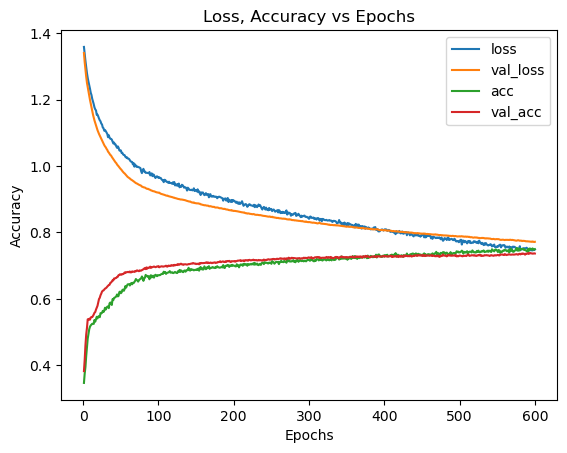

In [42]:
#plot the learning curves
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'], label = 'acc')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [43]:
nn_model = model

In [44]:
nn_model.save("../model_for_optuna/nn_train_filter_mine_full.keras")

# Lgbm

In [5]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 3,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [6]:
sampler = TPESampler(seed=34)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-06-07 06:24:46,352] A new study created in memory with name: lightgbm
[I 2024-06-07 06:24:47,678] Trial 0 finished with value: 0.7522727272727273 and parameters: {'lambda_l1': 2.2235921283093174e-08, 'lambda_l2': 0.10493108045268075, 'num_leaves': 25, 'feature_fraction': 0.7797356118906864, 'bagging_fraction': 0.40833450899213125, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 0 with value: 0.7522727272727273.
[I 2024-06-07 06:24:50,918] Trial 1 finished with value: 0.8068181818181818 and parameters: {'lambda_l1': 1.895736870465762e-06, 'lambda_l2': 5.124927861531237e-07, 'num_leaves': 107, 'feature_fraction': 0.4080523658436415, 'bagging_fraction': 0.7890836708939143, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 1 with value: 0.8068181818181818.
[I 2024-06-07 06:24:55,196] Trial 2 finished with value: 0.7954545454545454 and parameters: {'lambda_l1': 0.18704037732254108, 'lambda_l2': 0.27453768913361337, 'num_leaves': 71, 'feature_fraction': 0.90188586

# Catboost

In [7]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [8]:
sampler = TPESampler(seed=1)
catstudy = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
catstudy.optimize(objective, n_trials=30)

[I 2024-06-07 06:35:33,035] A new study created in memory with name: catboost
[I 2024-06-07 06:35:42,407] Trial 0 finished with value: 0.69375 and parameters: {'iterations': 475, 'learning_rate': 0.027583475549166746, 'depth': 4, 'l2_leaf_reg': 1.0551779964424746e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0931628460945333e-07, 'bagging_temperature': 0.923385947687978, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 0 with value: 0.69375.
[I 2024-06-07 06:38:02,537] Trial 1 finished with value: 0.6977272727272728 and parameters: {'iterations': 585, 'learning_rate': 0.006892694481137703, 'depth': 8, 'l2_leaf_reg': 1.10795595820296e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7999391045172093, 'bagging_temperature': 0.27387593197926163, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 1 with value: 0.6977272727272728.
[I 2024-06-07 06:39:39,047] Trial 2 finished with value: 0.6073863636363637 and parameters: {'iterations': 226, 'learning_rate': 0.0024900208186

KeyboardInterrupt: 

# RF

In [9]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42,
                    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [10]:
sampler = TPESampler(seed=1)
rfstudy = optuna.create_study(study_name="rf", direction="maximize", sampler=sampler)
rfstudy.optimize(objective, n_trials=20)

[I 2024-06-07 06:39:58,592] A new study created in memory with name: rf
[I 2024-06-07 06:40:09,188] Trial 0 finished with value: 0.7829545454545455 and parameters: {'n_estimators': 66, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7829545454545455.
[I 2024-06-07 06:40:10,204] Trial 1 finished with value: 0.6085227272727273 and parameters: {'n_estimators': 19, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7829545454545455.
[I 2024-06-07 06:40:19,050] Trial 2 finished with value: 0.7619318181818182 and parameters: {'n_estimators': 60, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7829545454545455.
[I 2024-06-07 06:40:22,786] Trial 3 finished with value: 0.7528409090909091 and parameters: {'n_estimators': 25, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7829545454545455.
[I 2024-06-07 06:40:33,84

# Xgb

In [11]:

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def objective(trial):

    # Suggest hyperparameters
    param = {
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'verbosity': 0,
        'objective': 'multi:softprob',
        'num_class': 3,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_float('eta', 1e-8, 1.0, log=True)
        param['gamma'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])

    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train the model
    bst = xgb.train(param, dtrain)

    # Make predictions
    preds = bst.predict(dtest)
    pred_labels = np.argmax(preds, axis=1)

    # Evaluate the model
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

In [12]:
xgstudy = optuna.create_study(direction='maximize')

# Run the optimization
xgstudy.optimize(objective, n_trials=30)


[I 2024-06-07 06:51:21,309] A new study created in memory with name: no-name-9e5a6448-55e8-4072-94ad-4de35c5439a0
[I 2024-06-07 06:51:21,521] Trial 0 finished with value: 0.5630681818181819 and parameters: {'iterations': 586, 'booster': 'gbtree', 'lambda': 0.016081791463866305, 'alpha': 0.007182128662580591, 'max_depth': 2, 'eta': 0.018268001055965696, 'gamma': 1.6937111524109848e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5630681818181819.
[I 2024-06-07 06:51:21,698] Trial 1 finished with value: 0.5068181818181818 and parameters: {'iterations': 538, 'booster': 'gbtree', 'lambda': 0.03333121372246222, 'alpha': 0.0030891214817637775, 'max_depth': 1, 'eta': 8.025504154841093e-07, 'gamma': 0.14040676811878913, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5630681818181819.
[I 2024-06-07 06:51:22,003] Trial 2 finished with value: 0.5892045454545455 and parameters: {'iterations': 944, 'booster': 'gbtree', 'lambda': 5.988238477134856e-07, 'alpha': 0.185060582

# Extratree

In [55]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [63]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def objective(trial):

    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Initialize the Extra Trees Classifier with suggested hyperparameters
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# etstudy = optuna.create_study(direction='maximize')

# # Run the optimization
# etstudy.optimize(objective, n_trials=100)

# # Print the best trial
# print(f"Best trial: {study.best_trial.value}")
# print(f"Best hyperparameters: {study.best_trial.params}")

# Ensemble

In [28]:
# nn_model = tf.keras.models.load_model("best_hyper_param_model_tuned.keras")

OSError: Unable to open file (file signature not found)

In [79]:
class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
      
      # lgb2_params = {'iterations':480,'boosting_type': 'gbdt', 'colsample_bynode': 0.4, 'num_leaves': 512, 'learning_rate': 0.20739204887409862, 'top_rate': 0.24580180437997, 'other_rate': 0.1358399720078459, 'reg_alpha': 0.7658391062803355, 'reg_lambda': 3.7633798443857778, 'objective': 'multiclass', 'metric': 'multi_logloss', 'sub_feature': 0.9727140934276332, 'max_depth': 102, 'feature_fraction': 0.6300950667084424, 'num_class': 3, 'verbose': -1, 'early_stopping_round': 20}
      # lgb3_params = {'iterations': 160,'boosting_type': 'gbdt', 'colsample_bynode': 0.4, 'num_leaves': 256, 'learning_rate': 0.029568288655155973, 'top_rate': 0.4468264431945309, 'other_rate': 0.06511765521623775, 'reg_alpha': 0.3369711181525681, 'reg_lambda': 0.12165833723606245, 'objective': 'multiclass', 'metric': 'multi_logloss', 'sub_feature': 0.10439355097935865, 'max_depth': 97, 'feature_fraction': 0.6655295815024023, 'num_class': 3, 'verbose': -1, 'early_stopping_round': 20}
      # lgb4_params = {'iteratiolgb1_params = {'lambda_l1': 0.0003744733903733805, 'lambda_l2': 0.000514425170092784, 'num_leaves': 242, 'feature_fraction': 0.9627640138863334, 'bagging_fraction': 0.7995654808153547, 'bagging_freq': 1, 'min_child_samples': 12}ns': 160, 'boosting_type': 'gbdt', 'colsample_bynode': 0.4, 'num_leaves': 127, 'learning_rate': 0.11410728313122884, 'top_rate': 0.1515223979306919, 'other_rate': 0.05345439517861381, 'reg_alpha': 1.9490514716467415, 'reg_lambda': 4.239016677662103, 'objective': 'multiclass', 'metric': 'multi_logloss', 'sub_feature': 0.9402067855698549, 'max_depth': 189, 'feature_fraction': 0.4851342825407552, 'num_class': 3, 'verbose': -1, 'early_stopping_round': 20}
      # lgb5_params = {'iterations': 80 , 'boosting_type': 'goss', 'colsample_bynode': 0.4, 'num_leaves': 512, 'learning_rate': 0.13392078670624777, 'top_rate': 0.48992681223833845, 'other_rate': 0.17554042943033593, 'reg_alpha': 0.07837636335691844, 'reg_lambda': 3.1665165507767403, 'objective': 'multiclass', 'metric': 'multi_logloss', 'sub_feature': 0.8203377141442953, 'max_depth': 186, 'feature_fraction': 0.6497203329094585, 'num_class': 3, 'verbose': -1, 'early_stopping_round': 20}
      # params_xgb_2 = {'lambda': 2.9796779801323702e-08, 'alpha': 5.269972009634037e-06, 'max_depth': 31, 'eta': 0.16061804654989076, 'gamma': 3.2862951911289705e-07, 'grow_policy': 'depthwise', 'eval_metric': 'mlogloss', 'objective': 'multi:softmax'}
      # et_params = {'n_estimators': 423, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2}
      # rf_params = {'n_estimators': 563, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1}
      
      lgb1_params = study.best_params
      # lgb3_params = {'iterations': 160,'boosting_type': 'gbdt', 'colsample_bynode': 0.4, 'num_leaves': 256, 'learning_rate': 0.029568288655155973, 'top_rate': 0.4468264431945309, 'other_rate': 0.06511765521623775, 'reg_alpha': 0.3369711181525681, 'reg_lambda': 0.12165833723606245, 'objective': 'multiclass', 'metric': 'multi_logloss', 'sub_feature': 0.10439355097935865, 'max_depth': 97, 'feature_fraction': 0.6655295815024023, 'num_class': 3, 'verbose': -1, 'early_stopping_round': 20}
      # lgb4_params = {'iteratiolgb1_params = {'lambda_l1': 0.0003744733903733805, 'lambda_l2': 0.000514425170092784, 'num_leaves': 242, 'feature_fraction': 0.9627640138863334, 'bagging_fraction': 0.7995654808153547, 'bagging_freq': 1, 'min_child_samples': 12}ns': 160, 'boosting_type': 'gbdt', 'colsample_bynode': 0.4, 'num_leaves': 127, 'learning_rate': 0.11410728313122884, 'top_rate': 0.1515223979306919, 'other_rate': 0.05345439517861381, 'reg_alpha': 1.9490514716467415, 'reg_lambda': 4.239016677662103, 'objective': 'multiclass', 'metric': 'multi_logloss', 'sub_feature': 0.9402067855698549, 'max_depth': 189, 'feature_fraction': 0.4851342825407552, 'num_class': 3, 'verbose': -1, 'early_stopping_round': 20}
      # lgb5_params = {'iterations': 80 , 'boosting_type': 'goss', 'colsample_bynode': 0.4, 'num_leaves': 512, 'learning_rate': 0.13392078670624777, 'top_rate': 0.48992681223833845, 'other_rate': 0.17554042943033593, 'reg_alpha': 0.07837636335691844, 'reg_lambda': 3.1665165507767403, 'objective': 'multiclass', 'metric': 'multi_logloss', 'sub_feature': 0.8203377141442953, 'max_depth': 186, 'feature_fraction': 0.6497203329094585, 'num_class': 3, 'verbose': -1, 'early_stopping_round': 20}
      params_xgb_2 = xgstudy.best_params
      et_params = {'n_estimators': 394, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 13}
      rf_params = rfstudy.best_params
        
        
      models = {
        "nn": nn_model,
        "lgb1": lgb.LGBMClassifier(**lgb1_params),
        "rf": RandomForestClassifier(**rf_params),
        "xgb": XGBClassifier(**params_xgb_2),
        "et": ExtraTreesClassifier(**et_params),
      }
      return models

In [80]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=3000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        weighted_pred = weighted_pred/weighted_pred.sum(axis=1, keepdims=True)
        
        weighted_pred_labels = np.argmax(weighted_pred, axis=1)
        accuracy = accuracy_score(y_true, weighted_pred_labels)

        log_loss_score=log_loss(y_true, weighted_pred)
        return accuracy

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [81]:
features = X.columns
target = ["nforest_type"]

X_train = pd.DataFrame(X_train, columns= features)
y_train = pd.DataFrame(y_train, columns=target)

In [82]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val


In [83]:
import time
device = "cpu"

kfold = True
n_splits = 1 if not kfold else 5
random_state = 42
random_state_list = [42] 
n_estimators = 1000
early_stopping_rounds = 30
verbose = False
splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros((X_test.shape[0], 3))
ensemble_score = []
ensemble_acc_score = []
weights = []
trained_models = {'xgb':[]}
    
for i, (X_train_, X_val, y_train_, y_val_) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits


    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    start_time_fold = time.time()
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        start_time = time.time()
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name)  :
            if 'lgb' in name:
                model.fit(X_train_.values, y_train_.values, eval_set=[(X_val.values, y_val_.values)])
            else:
                model.fit(X_train_, y_train_, eval_set=[(X_val, y_val_)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        elif 'nn' in name:
            pass
        else:
            model.fit(X_train_, y_train_)

            
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
        
        if 'nn' in name:
            y_val_pred = np.array(model.predict(X_val))#[:,0]
            test_pred = np.array(model.predict(X_test))
        else:
            test_pred = model.predict_proba(X_test)
            y_val_pred = model.predict_proba(X_val)
        
        end_time = time.time()
        time_taken = end_time - start_time
        
        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        accuracy = accuracy_score(y_val_, y_val_pred_labels)
        
        score = log_loss(y_val_, y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] Accuracy Score: {accuracy:.5f}, time taken :{time_taken:.3f} secs')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
        
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val_, oof_preds)
    
    score = log_loss(y_val_, y_val_pred)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    accuracy = accuracy_score(y_val_, y_val_pred_labels)
    
    end_time_fold = time.time()
    time_taken = end_time_fold - start_time_fold
    
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] -------------------> Accuracy Score: {accuracy:.5f}, Logloss: {score:.5f}, fold time taken :{time_taken:.5f} secs')
    
    ensemble_score.append(score)
    ensemble_acc_score.append(accuracy)
    weights.append(optweights.weights)
    
    # Predict to X_test by the best ensemble weights
    _test_preds = optweights.predict(test_preds)
    test_predss += _test_preds / (n_splits * len(random_state_list))
    
    gc.collect()

55/55 [==============================] - 0s 1ms/step
nn [FOLD-0 SEED-42] Accuracy Score: 0.77076, time taken :0.638 secs
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.01196

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Start training from score -1.098297
[LightGBM] [Info] Start training from score -1.106140
[LightGBM] [Info] Start training from score -1.091455
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[Lig

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


rf [FOLD-0 SEED-42] Accuracy Score: 0.79129, time taken :83.041 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-0 SEED-42] Accuracy Score: 0.78371, time taken :19.099 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


et [FOLD-0 SEED-42] Accuracy Score: 0.70540, time taken :6.543 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Ensemble [FOLD-0 SEED-42] -------------------> Accuracy Score: 0.81591, Logloss: 0.48461, fold time taken :147.45033 secs
55/55 [==============================] - 0s 1ms/step
nn [FOLD-1 SEED-42] Accuracy Score: 0.77550, time taken :0.342 secs
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_by

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


rf [FOLD-1 SEED-42] Accuracy Score: 0.80013, time taken :80.662 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-1 SEED-42] Accuracy Score: 0.78592, time taken :17.778 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


et [FOLD-1 SEED-42] Accuracy Score: 0.70540, time taken :6.403 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Ensemble [FOLD-1 SEED-42] -------------------> Accuracy Score: 0.82854, Logloss: 0.45507, fold time taken :143.24283 secs
55/55 [==============================] - 0s 1ms/step
nn [FOLD-2 SEED-42] Accuracy Score: 0.78181, time taken :0.331 secs
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_by

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


rf [FOLD-2 SEED-42] Accuracy Score: 0.79571, time taken :80.043 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-2 SEED-42] Accuracy Score: 0.79318, time taken :20.012 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


et [FOLD-2 SEED-42] Accuracy Score: 0.71487, time taken :6.596 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Ensemble [FOLD-2 SEED-42] -------------------> Accuracy Score: 0.83012, Logloss: 0.45930, fold time taken :145.19650 secs
55/55 [==============================] - 0s 1ms/step
nn [FOLD-3 SEED-42] Accuracy Score: 0.77266, time taken :0.339 secs
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_by

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Start training from score -1.098533
[LightGBM] [Info] Start training from score -1.106140
[LightGBM] [Info] Start training from score -1.091219
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[Lig

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


rf [FOLD-3 SEED-42] Accuracy Score: 0.79444, time taken :79.852 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-3 SEED-42] Accuracy Score: 0.79255, time taken :18.895 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


et [FOLD-3 SEED-42] Accuracy Score: 0.71329, time taken :6.462 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Ensemble [FOLD-3 SEED-42] -------------------> Accuracy Score: 0.82602, Logloss: 0.47469, fold time taken :143.87822 secs
55/55 [==============================] - 0s 1ms/step
nn [FOLD-4 SEED-42] Accuracy Score: 0.76476, time taken :0.338 secs
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_by

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda

d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


rf [FOLD-4 SEED-42] Accuracy Score: 0.79444, time taken :81.277 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-4 SEED-42] Accuracy Score: 0.77929, time taken :17.066 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


et [FOLD-4 SEED-42] Accuracy Score: 0.70066, time taken :6.569 secs
Ensemble [FOLD-4 SEED-42] -------------------> Accuracy Score: 0.81086, Logloss: 0.47037, fold time taken :143.76100 secs


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [84]:
test = pd.read_csv("../Data/new_test.csv")
test = test[X.columns]
scaler.fit(test)
test_data = scaler.transform(test)

In [85]:
predict = []
for name, model in models.items():
  if "nn" in name:
    predict.append(model.predict(test_data))
  else:
    predict.append(model.predict_proba(test_data))


125/125 [==============================] - 0s 1ms/step
[LightGBM] [Warning] feature_fraction is set=0.5429890897002663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5429890897002663
[LightGBM] [Warning] lambda_l1 is set=6.011966165374881e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.011966165374881e-07
[LightGBM] [Warning] lambda_l2 is set=0.047586411976348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047586411976348
[LightGBM] [Warning] bagging_fraction is set=0.5782972411851028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782972411851028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Coding\forest_hack\.env\new_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


In [86]:
len(predict)

5

In [87]:
prediction = optweights.predict(predict)
prediction = np.argmax(prediction, axis=1)
prediction[:3]

array([2, 0, 0], dtype=int64)

In [88]:

prediction[:3]

array([2, 0, 0], dtype=int64)

In [89]:
submission = pd.read_csv("../sample_submission.csv")

In [90]:
submission["nforest_type"] = prediction

In [91]:
submission["nforest_type"] = submission["nforest_type"].map({0:'MDF', 1:'DDF', 2:'DEF'})

In [92]:
submission["nforest_type"].value_counts()

nforest_type
MDF    1575
DDF    1298
DEF    1127
Name: count, dtype: int64

In [93]:
submission.head()

,id,nforest_type
0,13467,DEF
1,12719,MDF
2,1054,MDF
3,13747,DDF
4,9453,MDF


In [94]:
submission.to_csv("../Output/output.csv", index=False)

In [29]:
def find_add(nums, target):
  if target < nums[0]: return 0
  if target > nums[-1]: return len(nums)

  left = 0
  right = len(nums) -1

  while left < right:
    middle = (right + left) // 2

    if nums[middle] == target:
      return middle
    if nums[middle] < target:
      left = middle +1
    if nums[middle] > target:
      right = middle -1

  print(middle, target)
  return middle if target < nums[middle] else middle +1


In [30]:

target = 2
nums = [1,3, 5, 7]
print(find_add(nums, target))

1 2
1


In [14]:
print((2+2)//2)

2
